# Resources 
To go along with this walk through I recommend reading chapter 3 of ISLR, available here: http://www-bcf.usc.edu/~gareth/ISL/index.html

---

# Table of Contents 
### Chapter 4
* [4.1 Overview of Classification](#overview)
* [4.2 Why Not Linear Legression](#linear-regression)
* [4.3 Logistic Regression](#logistic-regression)
    * [4.3.1 The Logistic Model](#logistic-model)
    * [4.3.2 Estimating the Regression Coefficients](#regression-coeff)
    * [4.3.3 Making Predictions](#predictions)
    * [4.3.4 Multiple Logistic Regression](#multiple-logistic-regression)
* [4.4 Linear Discriminant Analysis](#linear-discriminant-analysis)
            
---

# Key Terms
Here is a list of key terms that you can `cmd+f` to learn a bit more about. 
* classification
* categorical
* logistic regression
* K-nearest neighbor
* linear discriminant analysis
* likelihood
* maximum likelihood
* odds
* logit 
* log-odds
* sigmoid
* conditional probability
* z-statistic
* confounding

# 4.1 Overview of Classification <a class="anchor" id="overview"></a>
The linear regression model discussed in Chapter 3 assumes that the response variable Y is quantitative. But in many situations, the response variable is instead qualitative (example: eye color can be brown, blue, or green). Often qualitative variables are referred to as **categorical**. 

In this walk through we will look at different approaches for predicting a qualitative response, a process known as **classification**. 

Predicting a qualitative response for an observation can be referred to as classifying that observation, since it involves assigning the observation to a category, or class. 

On the other hand, often the methods used for classification first predict the probability of each of the categories of a qualitative variable, as the basis for making the classification. In this sense they also behave like regression methods!

In this walk through, we are going to discuss 3 of the most commonly used classifiers:
* Logistic Regression
* Linear Discriminant Analysis
* K-nearest neighbor

So lets start by getting a broad overview of the classification situation. Classification problems occur often, possibly even more often than regression problems. For example:

1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have?

2. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user’s IP address, past transaction history, and so forth.

3. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not.

Now, just as we did in the regression setting, in the classification setting we will also have a set of training observations: $(x_1,y_1),...,(x_n,y_n)$. Again, we want our classifier to perform well not only on the training data, but also on test observations that were not used to train the classifier- in other words it must be able to generalize well to new examples!

We will illustrate the concept of classification using the simulated *Default* data set. We are interested in predicting whether an individual will default on his or her credit card payment, on the basis of annual income and monthly credit card balance. In other words, we will predict **yes they will default** or **no they will not default**, given **two input features**, **Balance** and **Income**. 

The data set is displayed in the figure below. We have plotted annual income and monthly credit card balance for a subset of 10,000 individuals. The left-hand panel displays individuals who defaulted in a given month in orange, and those who did not in blue. (The overall default rate is about 3%, so we have plotted only a fraction of the individuals who did not default.) 

What can we already gather from the visualization? *It appears that individuals who defaulted tended to have higher credit card balances than those who did not.*

In the right-hand panel below, two pairs of boxplots are shown. The first shows the distribution of balance split by the binary default variable; the second is a similar plot for income. 

In this walk through, we learn how to build a model to predict **default ($Y$)** for any given value of balance $(X_1)$ and income $(X_2)$. Since $Y$ is not quantitative, the simple linear regression model of Chapter 3 is not appropriate.

In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Default.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

  default student      balance        income  default2  student2
1      No      No   729.526495  44361.625074         0         0
2      No     Yes   817.180407  12106.134700         0         1
3      No      No  1073.549164  31767.138947         0         0

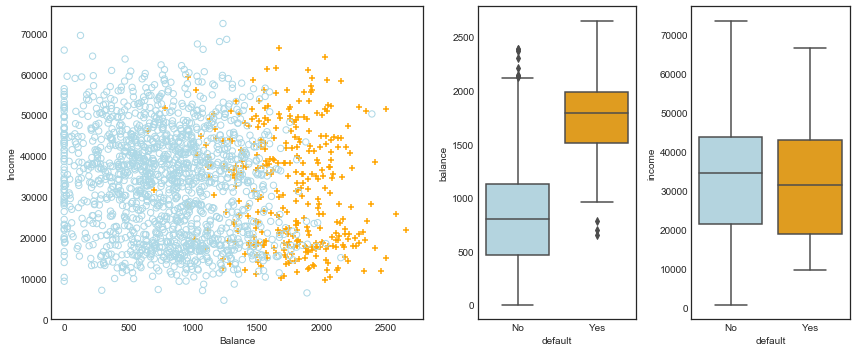

In [4]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='none')

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())


It is worth noting that the figure above displays a very pronounced relationship between the predictor balance and the response default. In most real applications, the relationship between the predictor and the response will not be nearly so strong. However, for the sake of illustrating the classification procedures discussed in this chapter, we use an example in which the relationship between the predictor and the response is somewhat exaggerated.

# 4.2 Why Not Linear Regression? <a class="anchor" id="linear-regression"></a>
Okay, so now that we have gone over that linear regression is not appropriate in the case of a qualitative response. But we haven't talked about **why**. 

Lets look at an example. Suppose that we are trying to predict the medical condition of a patient in the emergency room on the basis of her symptoms. In this simplified example, there are three possible diagnoses: 
1. stroke 
2. drug overdose 
3. epileptic seizure. 
We could consider encoding these values as a quantitative response variable $Y$, as follows:

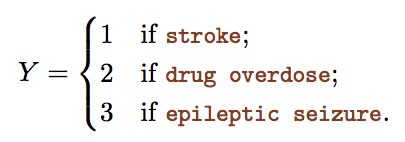

Using the above coding, we could use *least squares* to fit a linear regression model to predict $Y$ on the basis of a set of predictors $X_1,...,X_p$. However, this coding implies an ordering to the outcomes, putting **drug overdose** in between **stroke** and **epileptic seizure**, and insisiting that the difference between stroke and drug overdose is the same as the difference between drug overdose and epileptic seizure. In practice, there is no real reason for this to be the case. For instance, you could choose an equally reasonable coding:

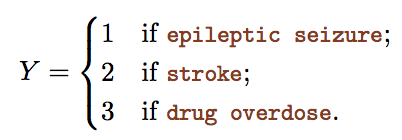

which would imply a totally different relationship among the three conditions. Each of these codings would produce fundamentally different linear models that would ultimately lead to different sets of predictions on test observations!

If the response variable’s values did take on a natural ordering, such as *mild, moderate, and severe*, and we felt the gap between *mild and moderate* was similar to the gap between *moderate and severe*, then a 1, 2, 3 coding would be reasonable. Unfortunately, in general there is no natural way to convert a qualitative response variable with more than two levels into a quantitative response that is ready for linear regression.

For a binary (two level) qualitative response, the situation is better. For instance, perhaps there are only two possibilities for the patient’s medical condition: stroke and drug overdose. We could then potentially use the dummy variable approach from the linear regression walk through to code the response as follows:

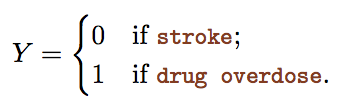

We could then fit a linear regression to this binary response, and predict drug overdose if $\hat{Y} > 0.5$ and stroke otherwise. In the binary case it is not hard to show that even if we flip the above coding, linear regression will produce the same final predictions.

For a binary response with a 0/1 coding as above, regression by least squares **does make sense**; it can be shown that the $X\hat{\beta}$ obtained using linear regression is in fact an estimate of $Pr(drug\;overdose\;|\;X)$ (probability of drug overdose given X) in this special case. However, if we use linear regression, some of our estimates might be outside the [0, 1] interval (see figure 4.2 below), **making them hard to interpret as probabilities!** Nevertheless, the predictions provide an ordering and can be interpreted as crude probability estimates.

## Figure 4.2

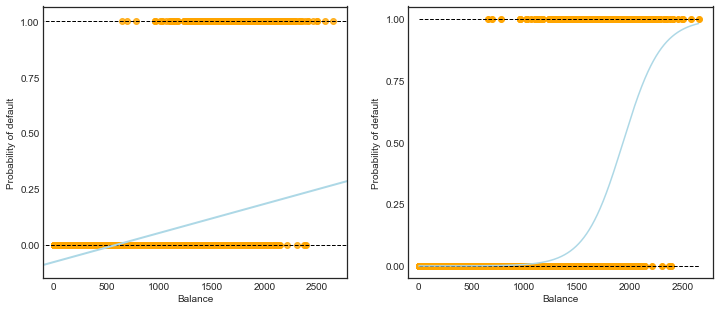

In [5]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)


However, the dummy variable approach cannot be easily extended to accommodate qualitative responses with more than two levels. For these reasons, it is preferable to use a classification method that is truly suited for qualitative response values, such as the ones presented next.

# 4.3 Logistic Regression <a class="anchor" id="logistic-regression"></a>
Okay, so now I want us to take a look at the Default data set again. See how the response **default** falls into two categories, **Yes** or **No**. Rather than modeling this response $Y$ directly, logistic regression models the **probability** that $Y$ belongs to a particular category! 


For the Default data, logistic regression models the probability of that a person will default. For example, the probability that a person will default given balance can be written as:
$$Pr(default = Yes\;|\;balance)$$
The values of $Pr(default = Yes\;|\;balance)$, which we will abbreviate $p(balance)$ (where p is a probability function based on the parameter balance), will range between 0 and 1. Then, for any given **balance**, a prediction can be made for whether the user will default or not. 

For example, one might predict $default = Yes$ for any individual for whom $p(balance) > 0.5$

Alternatively, if a company wishes to be conservative in predicting individuals who are at risk for default, then they may choose to use a lower threshold, such as $p(balance) > 0.1$.

## 4.3.1 The Logistic Model <a class="anchor" id="logistic-model"></a>
Okay so the question now arises: how should we model the relationship between:
$$p(X) = Pr(Y=\;1|\;X)$$ 
and:
$$X$$

In other words how do we model how the probability that Y = 1 (a person does default) based on their balance?

We have already talked about the idea of using the linear regression model to represent these probabilities:
$$p(X) = \beta_0 + \beta_1X$$
If we use this approach to predict default=Yes using balance, then we obtain the model shown in the left-hand panel of Figure 4.2. Here we see the problem with this approach: for balances close to zero we predict a negative probability of default; if we were to predict for very large balances, we would get values bigger than 1. These predictions are not sensible, since of course the true probability of default, regardless of credit card balance, must fall between 0 and 1.

This problem is not unique to the credit default data. Any time a straight line is fit to a binary response that is coded as 0 or 1, in principle we can always predict p(X) < 0 for some values of X and p(X) > 1 for others (unless the range of X is limited).

To avoid this problem, we must model p(X) using a function that gives outputs between 0 and 1 for all values of X. Many functions meet this description. In logistic regression, we use the logistic function:

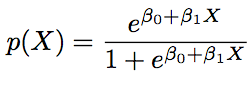

Remember, this is the same formula as the one we saw for the hypothesis in the machine learning walk through on logistic regression. 

To fit this model, we will use a method called **maximum likelihood**, which we discuss in the next section. 

The right-hand panel of Figure 4.2 illustrates the fit of the logistic regression model to the Default data. Notice that for low balances we now predict the probability of default as close to, but never below, zero. Likewise, for high balances we predict a default probability close to, but never above, one. The logistic function will always produce an S-shaped curve of this form, and so regardless of the value of X, we will obtain a sensible prediction.

We also see that the logistic model is better able to capture the range of probabilities than is the linear regression model in the left-hand plot. The average fitted probability in both cases is 0.0333 (averaged over the training data), which is the same as the overall proportion of defaulters in the data set.

Now if we manipulate the logistic formula above we can see that:

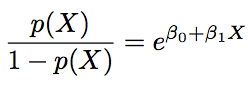

This quantity is known as the **odds**, and can take on any value between zero and infinity. Values of the odds close to 0 and ∞ indicate very low and very high probabilities of default, respectively. 

For example, on average 1 in 5 people with an odds of 1/4 will default, since p(X) = 0.2 implies an
odds of 0.2/(1-0.2) = 1/4. Likewise on average nine out of every ten people with an odds of 9 will default, since p(X) = 0.9 implies an odds of 0.9/(1−0.9) = 9. Odds are traditionally used instead of probabilities in horse-racing, since they relate more naturally to the correct betting strategy.

If we take the logarithm of both sides, we arrive at: 

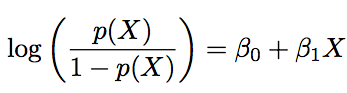

The left-hand side is called the **log-odds** or **logit**. We see that the logistic regression model has a logit that is linear in X.

Recall from Chapter 3 (linear regression walk through) that in a linear regression model, $\beta_1$ gives the average change in Y associated with a one-unit increase in X. 

In contrast, in a logistic regression model, increasing X by one unit changes the log odds by β1 (4.4), or equivalently it multiplies the odds by $e^{\beta_1}$. However, because the relationship between p(X) and X in the logistic function is not a straight line, $\beta_1 does **not** correspond to the change in p(X) associated with a one-unit increase in X. The amount that p(X) changes due to a one-unit change in X will depend on the current value of X0-because it is not linear so slope is dependent on *position*!

But regardless of the value of X, if β1 is positive then increasing X will be associated with increasing p(X), and if β1 is negative then increasing X will be associated with decreasing p(X). The fact that there is not a straight-line relationship between p(X) and X, and the fact that the rate of change in p(X) per unit change in X depends on the current value of X, can also be seen by inspection of the right-hand panel of Figure 4.2.

## Background on the Odds
The question may still be coming up (it was for me) in your mind: "how do I interpret the Odds Ratios in Logistic Regression?"

When a binary outcome variable is modeled using logistic regression, it is assumed that the logit transformation of the outcome variable has a linear relationship with the predictor variables.  This makes the interpretation of the regression coefficients somewhat tricky.  Let's walk through the concept of odds ratio and try to interpret the logistic regression results using the concept of odds ratio in a couple of examples.

### From probability to odds to log of odds
#### First: probability -> odds
Everything starts with the concept of probability.  Let’s say that the probability of success of some event is:
$$0.8$$  
Then the probability of failure is:
$$1 - 0.8 = 0.2$$
The **odds of success** are defined as the ratio of the **probability of success** over the **probability of failure**:
$$odds\;of\;success = \frac{probability\;of\;success}{probability\;of\;failure}$$
In our example, the odds of success are:
$$\frac{0.8}{0.2} = 4$$
This means that the odds of success are 4 to 1. If the probability of success is 0.5, (i.e. a 50-50% chance), then the odds of success is: 1 to 1
$$\frac{0.5}{0.5} = 1$$
The transformation from probability to odds is a monotonic transformation, meaning the odds increase as the probability increases or vice versa. Probability ranges from 0 and 1.  Odds range from 0 and positive infinity.  Below is a table of the transformation from probability to odds and we have also plotted for the range of p less than or equal to .9.

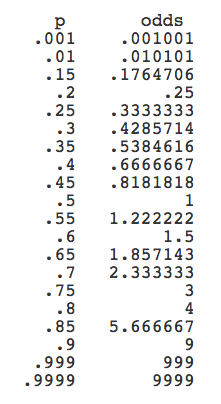

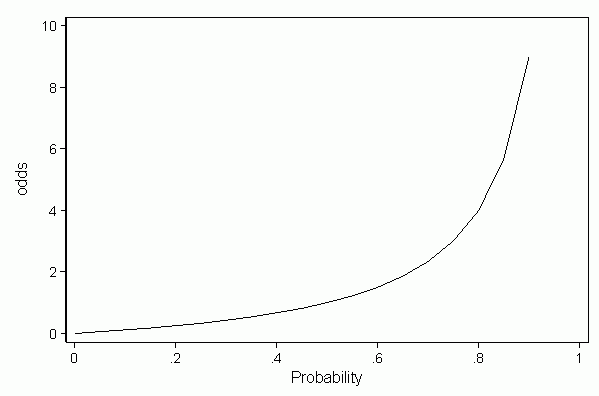

#### Second: odds -> log of odds
The transformation from **odds** to **log of odds** is the log transformation.  Again this is a monotonic transformation.  That is to say, the greater the odds, the greater the log of odds and vice versa. The table below shows the relationship among the probability, odds and log of odds.  We have also shown the plot of log odds against odds.

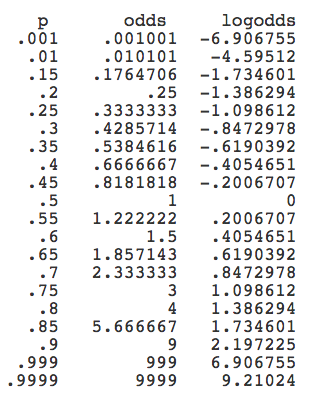

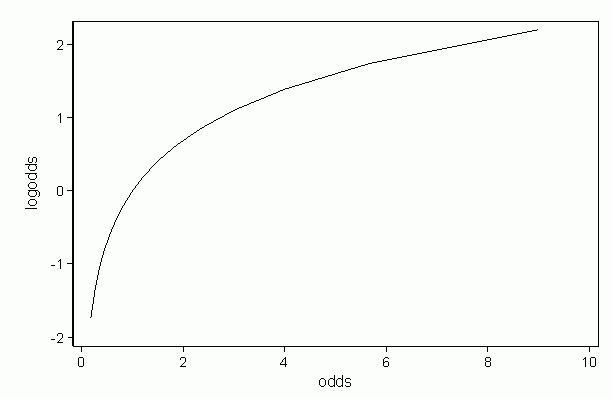

Okay, so now we can clearly see how we arrive at the log odds mechanically, but the question still remains: *why* do we take all the trouble of doing this transformation?? 
* One reason is that it is usually difficult to model a variable which has restricted range, such as probability.  This transformation is an attempt to get around the restricted range problem.  It maps probability ranging between 0 and 1 to log odds ranging from negative infinity to positive infinity.
* Another reason is that among all of the infinitely many choices of transformation, the log of odds is one of the easiest to understand and interpret.  This transformation is called **logit transformation.**

A logistic regression model allows us to establish a relationship between a binary outcome variable and a group of predictor variables.  It models the logit-transformed probability as a linear relationship with the predictor variables. (continue reading more at here: https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/)

## Background on the Logit
Now that we went over the **odds** and touched on the **logit**, lets go over the logit in more detail. 

So, remember, the logit (L) of a probability (p) is defined as:
$$Logit = ln\big(\frac{probability}{1-probability}\big)= ln\big(\;\frac{probability\;of\;success}{probability\;of\;failure}\big)$$
or simplified:
$$L = ln\big(\frac{p}{1-p}\big)$$
the term:
$$\frac{p}{1-p}$$
is called the **odds** (always intuitively think probability of success over failure). 

If we then try and solve for p, we find: 
$$p = \frac{e^L}{1+e^L} = \frac{1}{1+e^{-L}}$$
Note that this is exactly what we saw earlier in this walk through, as in:

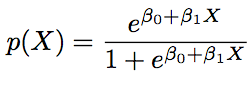

Okay, so now that we have gotten to that point, lets think about this. Probabilities can range from zero to one, whereas logits can be any real number. 

A probability of 0.50.5 corresponds to a logit of 0. Negative logit values indicate probabilities smaller than 0.5, positive logits indicate probabilities greater than 0.5. The relationship is symmetrical: Logits of −0.2−0.2 and 0.2 correspond to probabilities of 0.45 and 0.55, respectively. Note: The absolute distance to 0.5 is identical for both probabilities.

Here is the non-linear relationship between logits and probabilities:

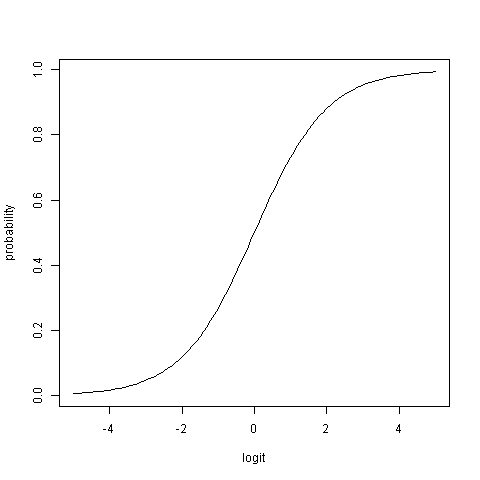

## Background: Logit and Sigmoid Functions
Lets try and relate back to what we learned in the machine learning lecture for logistic regression and the sigmoid function. 

Again, if we are given a probability p, the corresponding odds are calculated as:
$$\frac{p}{1-p}$$

The **logit function** is simply the logarithm of the odds! 

Below is a plot of the logit function:

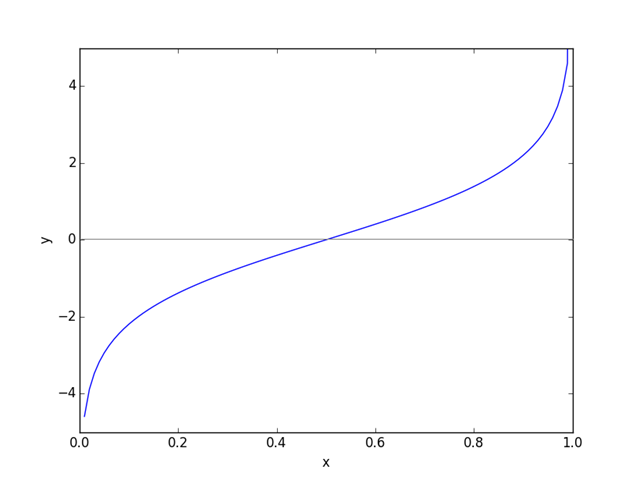

The value of the logit function heads towards infinity as p approaches 1 and towards negative infinity as it approaches 0.

Remember, we want to be asking **why** we are using the logit function! Well, the main reason is because the logit function maps probabilities (which are values in the range [0, 1]) to the full range of real numbers! In particular, if you are working with “yes-no” (binary) inputs it can be useful to transform them into real-valued quantities prior to modeling. This is essentially what happens in logistic regression.

This is where the sigmoid function comes in-the inverse of the logit function is the sigmoid function! 

So, if we remember the logit is:
$$Logit = ln\big(\frac{p}{1-p}\big)$$
and the sigmoid is defined as:
$$\sigma(x) = \frac{1}{1+e^{-x}}$$
then the sigmoid in our case respectively becomes:
$$sigmoid(logit(p)) = p = \frac{1}{1+e^{-logit(p)}}= \frac{1}{1+e^{-\frac{p}{1-p}}}$$ 

Below is a plot of the sigmoid function:

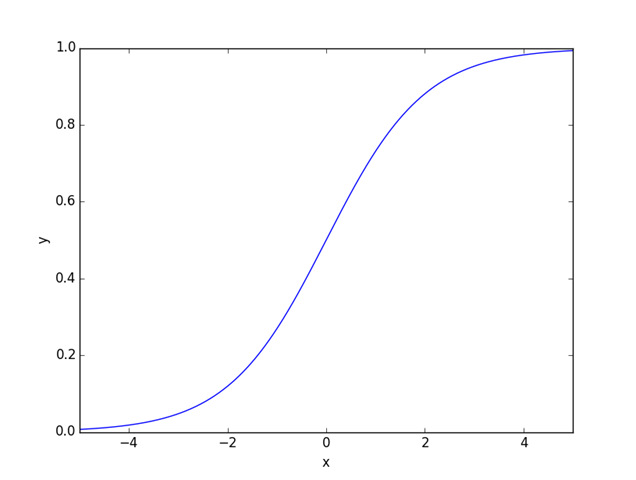

The sigmoid might be useful if you want to transform a real valued variable into something that represents a probability, which is exactly what we did in the logistic regression machine learning walkthrough. 

The term “sigmoid function” is used to refer to a class of functions with S-shaped curves. In most machine learning contexts, “sigmoid” usually refers specifically to the function described above.)

There are other functions that map probabilities to reals (and vice-versa), so what’s so special about the logit and sigmoid? One reason is that the logit function has the nice connection to odds described at the beginning of the article. A second is that the gradients of the logit and sigmoid are simple to calculate (try it and see). The reason why this is important is that many optimization and machine learning techniques make use of gradients, for example when estimating parameters for a neural network.

## Main intution to remember!
* The logit function maps probabilities in range 0-1 to real numbers ranging from negative infinity to positive infinity
* The sigmoid function maps aribitrary real values to the range 0-1 (aka a probability)

## 4.3.2 Estimating the Regression Coefficients <a class="anchor" id="regression-coeff"></a>
Here is where we are at: we are taking what was the equation for linear regression, and mapping it to a range 0-1 to represent the probability of a certain class. Here is the formula that we arrive at: 

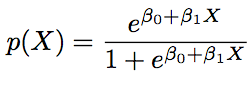

At this point in time, the coefficients $\beta_0$ and $\beta_1$ are not known, and must be estimated based on the available training data. 

In Chapter 3, we used the **least squares** approach to estimate the unknown linear regression coefficients. Although
we could use (non-linear) least squares to fit the model, the more general method of **maximum likelihood** is preferred, since it has better statistical properties.

The basic intuition behind using maximum likelihood to fit a logisitic regression model is as follows: we seek estimates for $\beta_0$ and $\beta_1$ such that the predicted probability $\hat{p}(x_i)$ of default for each individual, using the equation above, corresponds as closely as possible to the inividuals observed default status. 

In other words, we try to find $\hat{\beta_0}$ and $\hat{\beta_1}$ such that plugging these estimates into the model for p(X), seen here:

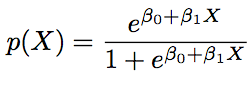

yields a number close to 1 for all individuals who defaulted , and a number close to zero for all individuals who did not. 
## Note: For best background on MLE please look at my notebooks on bayesian ab testing, and bayesian statistics and probability
## Background 1. Maximum Likelihood Estimation

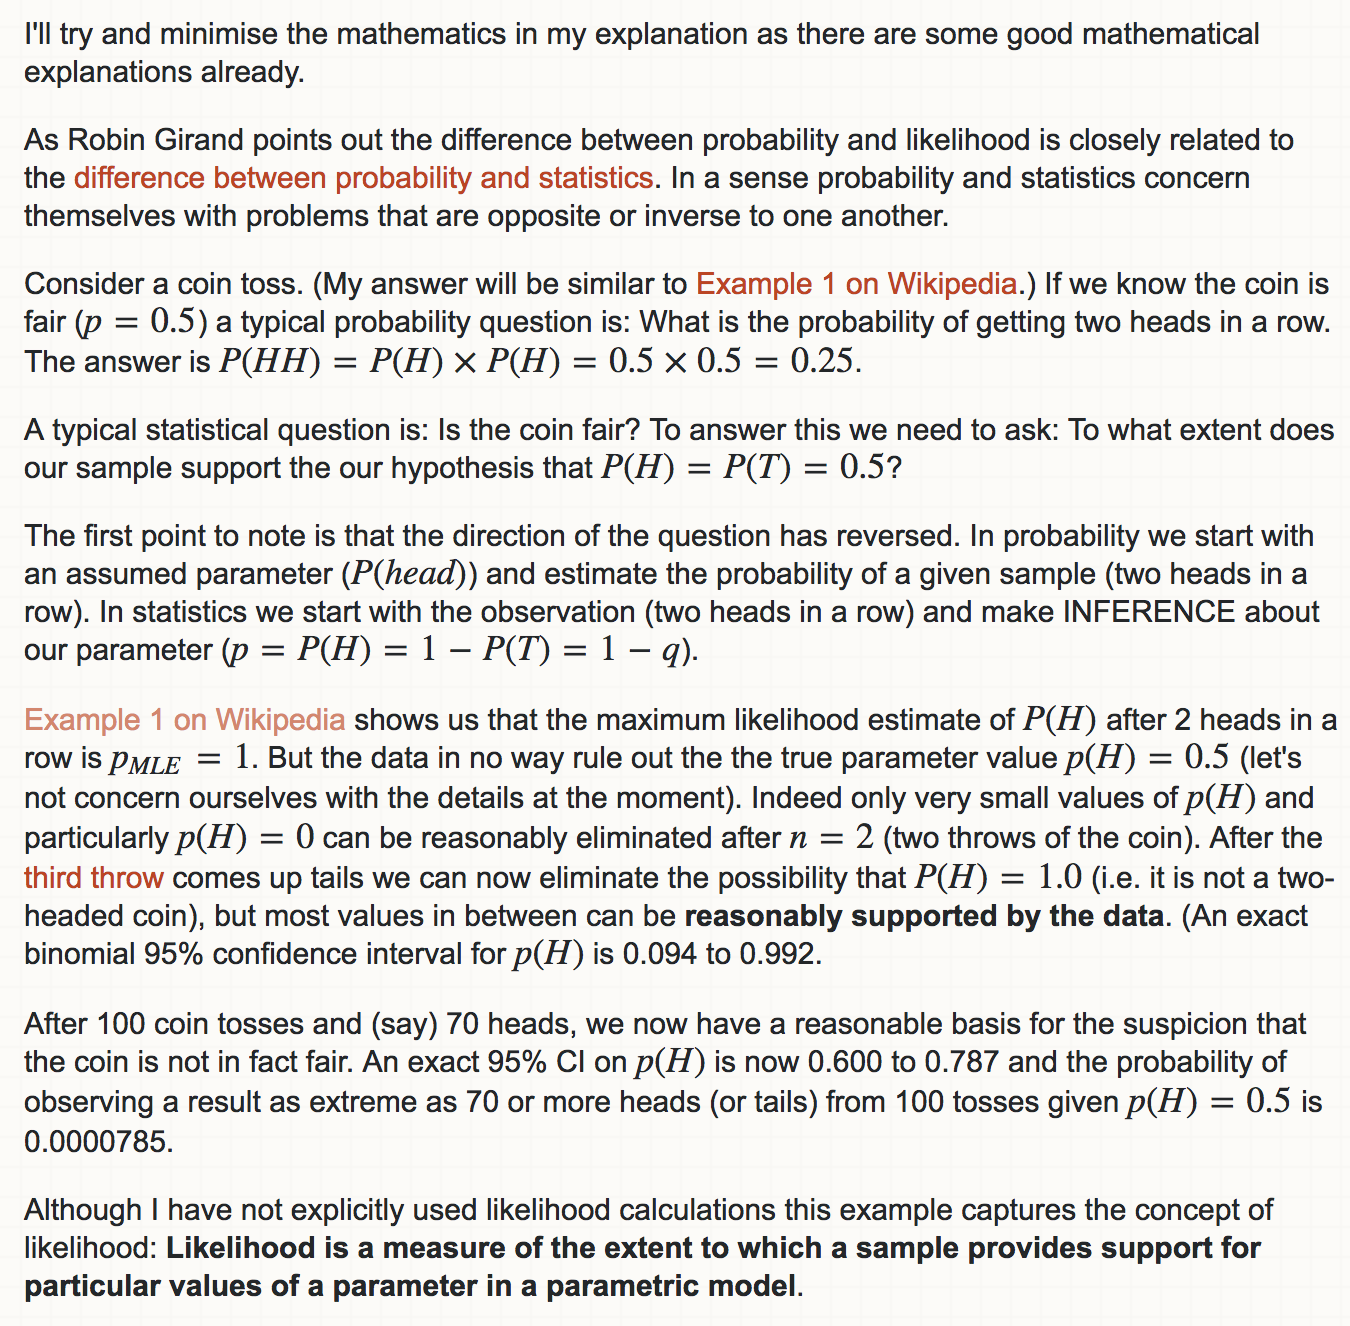

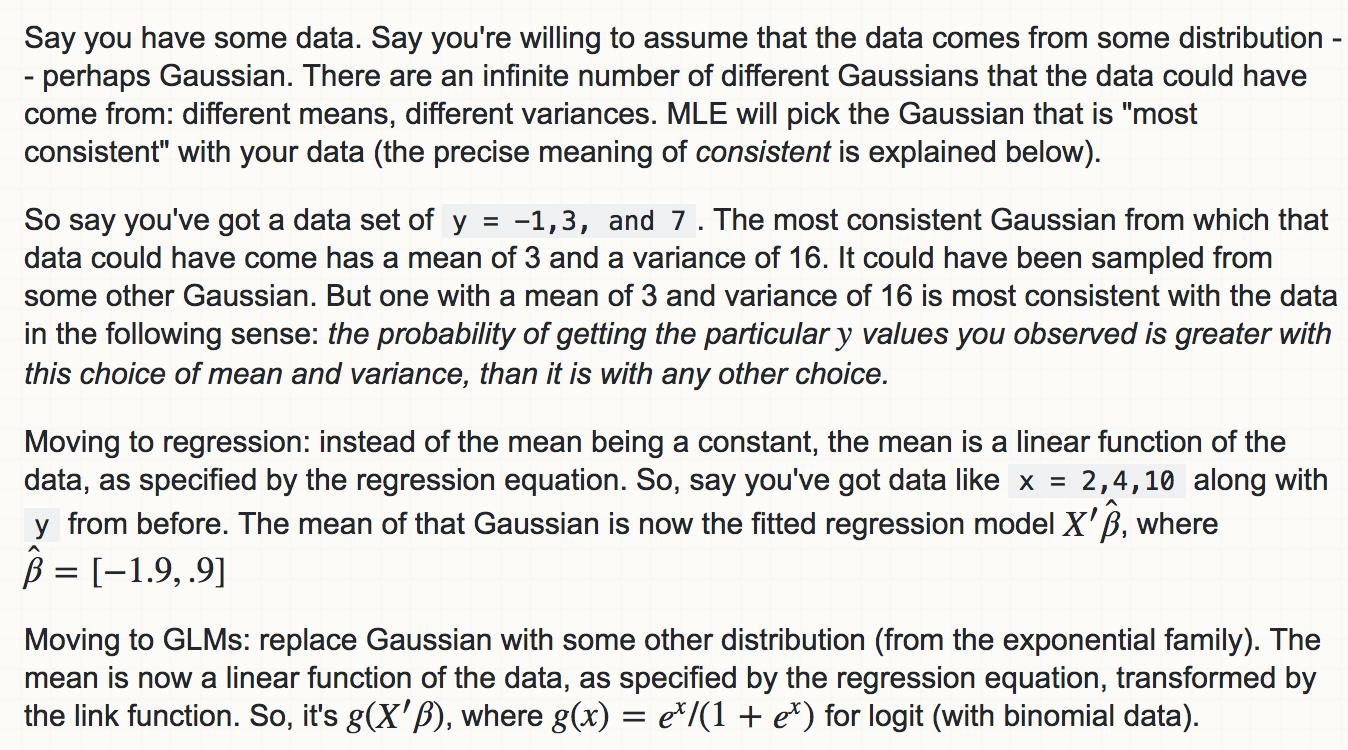

And here is a great video for a deeper understanding: https://www.youtube.com/watch?v=MIQuaGwuTY8

And another: https://www.youtube.com/watch?v=XepXtl9YKwc&t=113s

## Background 2. Even deeper background on MLE 
Okay so we have gone into a high level overview of what Maximum Likelihood Estimation is, but I still feel as though there are missing pieces, so lets continue to dive further. You can skip this section if you want.

### Probability 
The concept of likelihood, introduced by Sir R. A. Fisher, is closely related to the more common concept of probability. We speak about the probability of observing events. For example, for an unbiased coin, the probability of observing heads is 0.5 for every toss. This is taken to mean that if a coin were tossed a large number of times then we would expect, on average, to find half of the time the coin landed heads, half of the time tails.

There are certain laws of probability that allow us to make inferences and predictions based on probabilistic information. For example, the probabilities of different outcomes for a certain event must always add up to 1: if there is a 20% chance of rain today, there must be an 80% chance of no rain. Another very common law is that if two events are independent of one another (that is, they in no way influence each other), then the probability of certain pairs of outcomes will be the product of the two outcomes by themselves: if we toss a coin twice, the probability of getting 2 heads is 0.5 times 0.5 = 0.25.

### Models 
When we speak about the probability of observing events such as the outcome of a toss of a coin, we are implicitly assuming some kind of model, even in this simple case. In the case of a coin, the model would state that there is some certain, fixed probability for the particular outcomes. This model would have one parameter, p the probability of the coin landing on heads. If the coin is fair, then p=0.5. We can then speak about the probability of observing an event, given specific parameter values for the model. In this simple case, if p =0.5, then the probability of the coin landing heads on any one toss is also 0.5.

In the case of this simple example, it does not seem that we have gained very much - we seem to be merely calling what was previously a simple probability the parameter of a model. As we shall see, however, this way of thinking provides a very useful framework for expressing more complex problems.


### Conditional Probability
In the real world, very few things have absolute, fixed probabilities. Many of the aspects of the world that we are familiar with are not truly random. Take for instance, the probability of developing schizophrenia. Say that the prevalence of schizophrenia in a population is 1%. If we know nothing else about an individual, we would say that the probability of this individual developing schizophrenia is 0.01. In mathematical notation:
$$P(Sz) = 0.01$$
We know from empirical research, however, that certain people are more likely to develop schizophrenia than others. For example, having a schizophrenic first-degree relative greatly increases the risk of becoming schizophrenic. The probability above is essentially an average probability, taken across all individuals both with and without schizophrenic first-degree relatives.

The notion of conditional probability allows us to incorporate other potentially important variables, such as the presence of familial schizophrenia, into statements about the probability of an individual developing schizophrenia. Mathematically, we write:
$$P(X\;|\;Y)$$
meaning the probability of X *conditional on Y* or *given Y*. In our example we could write:
$$P\big(Sz\;|\;first\;degree\;relative\;has\;Sz\big)$$
and:
$$P\big(Sz\;|\;first\;degree\;relative\;does\;not\;have\;Sz\big)$$
Whether or not these two values differ is an indication of the influence of familial schizophrenia upon an individual's chances of developing schizophrenia.

Previously, we mentioned that all probability statements depend on some kind of model in some way. The probability of an outcome will be conditional upon the parameter values of this model. In the case of the coin toss:
$$P (H\;|\;p=0.5)$$
where H is the event of obtaining a head and p is the model parameter, set at 0.5.

Let's think a little more carefully about what the full model would be for tossing a coin, if p is the parameter. What do we know about coin tossing?
* The outcome is a discrete, binary outcome for each toss - it is either heads or tails.
* We assume that the probability of either outcome does not change over time.
* We assume that the outcome of each toss of a coin can be regarded as independent from all other outcomes. That is, getting five heads in a row does not make it any more likely to get a tail on the next trial.
* In the case of a 'fair' coin, we assume a 50:50 chance getting either heads or tails - that is, p=0.5.

Say we toss a coin a number of times and record the number of times it lands on heads. The probability distribution that describes just this kind of scenario is called the binomial probability distribution. It is written as follows:
$$\frac{n!}{h!(n-h)!}p^h(1-p)^{n-h}$$
Let's take a moment to work through this. The notation is as follows:
* n = total number of coin tosses
* h = number of heads obtained
* p = probability of obtaining a head on any one toss
* ! = factorial, ie 5! = 5*4*3*2*1=120

We can think of this equation in two parts. The second part ($p^h(1-p)^{n-h}$)involves the joint probability of obtaining h heads (and therefore n-h tails) if a coin is tossed n times and has probability p of landing heads on any one toss (and therefore probability 1-p of landing tails). *Because we have assumed that each of the n trails is independent and with constant probability the joint probability* of obtaining h heads and n-h tails is simply the product of all the individual probabilities. Imagine we obtained 4 heads and 5 tails in 9 coin tosses. Then:
$$p^4(1-p)^5$$
is simply convenient notation for:
$$p*p*p*p*(1-p)*(1-p)*(1-p)*(1-p)*(1-p)$$
The first half of the binomial distribution function is concerned with the fact that there is more than 1 way to get, say, 4 heads and 5 tails if a coin is tossed 9 times. We may observe:
$$H, T, H, H, T, T, H, T, T$$
or
$$T, H, H, T, H, T, T, H, T$$
or even
$$H, H, H, H, T, T, T, T, T$$
Every one of the permutations is assumed to have equal probability of occurring - the coefficient:
$$\frac{n!}{h!(n-h)!}$$
represents the total number of permutations that would give 4 heads and 5 tails.

So, the probability of obtaining 4 heads and 5 tails for a fair coin is:
$$\frac{9!}{4!5!}0.5^4*0.5^5=0.246$$

### Model Fitting
Okay, now we are in a position to introduce likelihood! If the probability of an event X dependent on model parameters p is written:
$$P(\;X\;|\;p\;)$$
then we would talk about the likelihood as:
$$L(\;p\;|\;X\;)$$
that is saying "*the likelihood of the parameters given the data*"

For most sensible models, we will find that certain data are more probable than other data. The aim of maximum likelihood estimation is to find the parameter value(s) that makes the observed data most likely. This is because the likelihood of the parameters given the data is defined to be equal to the probability of the data given the parameters.

**If we were in the business of making predictions based on a set of solid assumptions, then we would be interested in probabilities - the probability of certain outcomes occurring or not occurring.**

However, **in the case of data analysis, we have already observed all the data: once they have been observed they are fixed, there is no 'probabilistic' part to them anymore (the word data comes from the Latin word meaning 'given'). We are much more interested in the likelihood of the model parameters that underly the fixed data.**

**Probability**: knowing parameters -> Prediction of outcome

**Likelihood**: Observation of data -> Estimation of parameters

### A Simple Example of MLE
To re-iterate, the simple principle of maximum likelihood parameter estimation is this: find the parameter values that make the observed data most likely. How would we go about this in a simple coin toss experiment? That is, rather than assume that p is a certain value (0.5) we might wish to find the maximum likelihood estimate (MLE) of p, given a specific dataset.

Beyond parameter estimation, the likelihood framework allows us to make tests of parameter values. For example, we might want to ask whether or not the estimated p differs significantly from 0.5 or not. This test is essentially asking: is there evidence that the coin is biased? We will see how such tests can be performed when we introduce the concept of a likelihood ratio test below.

Say we toss a coin 100 times and observe 56 heads and 44 tails. Instead of assuming that p is 0.5, we want to find the MLE for p. Then we want to ask whether or not this value differs significantly from 0.50.

How do we do this? We find the value for p that makes the observed data most likely! 

As mentioned, the observed data are now fixed. They will be constants that are plugged into our binomial probability model:
* n = 100 (total number of tosses)
* h = 56 (total number of heads)

Imagine that p was 0.5. Plugging this value into our probability model as follows:
$$L(p=0.5\;|\;data)=\frac{100!}{56!44!}*0.5^{56}*0.5^{44} = 0.0389$$
But what is p was 0.52 instead?
$$L(p=0.52\;|\;data)=\frac{100!}{56!44!}*0.52^{56}*0.48^{44} = 0.0581$$

So from this we can conclude that p is more likely to be 0.52 than 0.5. We can tabulate the likelihood for different parameter values to find the maximum likelihood estimate of p:

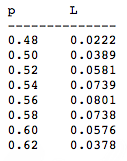

If we graph these data across the full range of possible values for p we see the following likelihood surface:

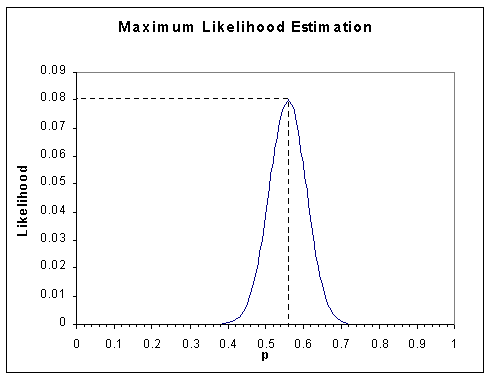

We see that the maximum likelihood estimate for p seems to be around 0.56. In fact, it is exactly 0.56, and it is easy to see why this makes sense in this trivial example. The best estimate for p from any one sample is clearly going to be the proportion of heads observed in that sample. (In a similar way, the best estimate for the population mean will always be the sample mean.)

So why did we waste our time with the maximum likelihood method? In such a simple case as this, nobody would use maximum likelihood estimation to evaluate p. But not all problems are this simple! As we shall see, the more complex the model and the greater the number of parameters, it often becomes very difficult to make even reasonable guesses at the MLEs. The likelihood framework conceptually takes all of this in its stride, however, and this is what makes it the work-horse of many modern statistical methods.

### MLE in Practice
#### Analytic MLE
Sometimes we can write a simple equation that describes the likelihood surface (e.g. the line we plotted in the coin tossing example) that can be differentiated. In this case, we can find the maximum of this curve by setting the first derivative to zero. That is, this represents the peak of a curve, where the gradient of the curve turns from being positive to negative (going left to right). In theory, this will represent the maximum likelihood estimate of the parameter.

#### Numerical MLE
But often we cannot, or choose not, to write an equation that can be differentiated to find the MLE parameter estimates. This is especially likely if the model is complex and involves many parameters and/or complex probability functions (e.g. the normal probability distribution).

In this scenario, it is also typically not feasible to evaluate the likelihood at all points, or even a reasonable number of points, in the parameter space of the problem as we did in the coin toss example. In that example, the parameter space was only one-dimensional (i.e. only one parameter) and ranged between 0 and 1. Nonetheless, because p can theoretically take any value between 0 and 1, the MLE will always be an approximation (albeit an incredibly accurate one) if we just evaluate the likelihood for a finite number of parameter values. For example, we chose to evaluate the likelihood at steps of 0.02. But we could have chosen steps of 0.01, of 0.001, of 0.000000001, etc. In theory and practice, one has to set a minimum tolerance by which you are happy for your estimates to be out. This is why computers are essential for these types of problems: they can tabulate lots and lots of values very quickly and therefore achieve a much finer resolution.

If the model has more than one parameter, the parameter space will grow very quickly indeed. Evaluating the likelihood exhaustively becomes virtually impossible - even for computers. This is why so-called optimisation (or minimisation) algorithms have become indispensable to statisticians and quantitative scientists in the last couple of decades. Simply put, the job of an optimisation algorithm is to quickly find the set of parameter values that make the observed data most likely. They can be thought of as intelligently playing some kind of hotter-colder game, looking for a hidden object, rather than just starting at one corner and exhaustively searching the room. The 'hotter-colder' information these algorithms utilise essentially comes from the way in which the likelihood changes as the they move across the parameter space. Note that it is precisely this type of 'rate of change' information that the analytic MLE methods use - differentiation is concerned with the rate of change of a quantity (i.e. the likelihood) with respect to some other factors (i.e. the parameters).

## Back to 4.3.2 
Okay so all of this intuition can be formalized using a mathematical equation called a **likelihood function:**
$$l(\beta_0,\beta_1) = \prod_{i:y_i=1}p(x_i)  \prod_{i':y_i'=0}(1-p(x_{i'})$$
where the estimates $\beta_0$ and $\beta_1$ are chosen to *maximize* this likelihood function. 

Breaking down this equation, it basically has two parts, the left product and the right product.

### Left product: 
This is taking all examples, i, where $y_i$ is 1, and then finding each probability of $x_i$ and multiplying them together. 

### Right product:
This is taking all examples, i', where $y_{i'}$ is 0, and then finding each probability of $x_{i'}$ and multiplying them together. 

For both the left and right product, remember, the probability $p$ is calculated using the logisitic function:
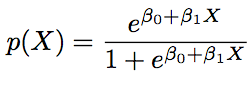

If we think about it this makes sense! The **likelihood function** parameterized by $p$, and $p$ is parameterized by $\beta_0$ and $\beta_1$. So we will try different values of $\beta_0$ and $\beta_1$, trying to get the highest value for the likelihood function. 

For instance, say we choose a very bad set of values for $\beta_0$ and $\beta_1$. Looking at the left side of the likelihood equation, here is what would happen. We would know that the actual observed value of y was 1. However, our p(x) would be very small, close to zero. That would be a bad estimate, and if a bunch of those bad estimates are made, the final likelihood would be very small, and we would need to try a different set of values for $\beta$. 

Note: in the machine learning walk through, we used MLE to create a cost function that we once again tried to *minimize*! However, in this walk through the MLE is used to create a likelihood function that we are trying to *maximize*. 

Note: the reason that the likelihood function uses the product operator to multiply all values together, is because they are each random independent trials. 

The table below shows the coefficient estimates and related information that
result from fitting a logistic regression model on the Default data in order to predict the probability of default=Yes using balance. We see that $\hat{\beta_1}=0.0055$. this indicates that an increase in balance is associated with an increase in the probability of default. To be precise, a one-unit increase in balance is associated with an increase in the log odds of default by 0.0055 units.

In [6]:
y = df.default2

### scikit-learn

In [7]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
classes:  [0 1]
coefficients:  [[ 0.00549891]]
intercept : [-10.65131887]


### statsmodels - Table 4.1

In [8]:
X_train = sm.add_constant(df.balance)
est = smf.Logit(y.ravel(), X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


Many aspects of the logistic regression output shown in Table 4.1 are similar to the linear regression output of Chapter 3. For example, we can measure the accuracy of the coefficient estimates by computing their standard errors. The z-statistic in Table 4.1 plays the same role as the t-statistic in the linear regression output, which was to determine if the null hypothesis could be rejected! In this case, the z-statistic is large, so there is great evidence that the null hypothesis can be rejected! 

For instance, the z-statistic associated with $\beta_1$ is equal to:
$$\frac{\hat{\beta_1}}{SE(\hat{\beta_1})}$$
And so a large (absolute) value of the z-statistic indicates evidence against the null hypothesis! 
$$H_0:\beta_1=0$$

This null hypothesis implies that:
$$p(X)=\frac{e^{\beta_0}}{1+e^{\beta_0}}$$
In other words, that the probability of default does not depend on balance. Since the p-value associated with balance in Table 4.1 is tiny, we can reject H0. In other words, we conclude that there is indeed an association between balance and probability of default.

The estimated intercept in Table 4.1 is typically not of interest; its main purpose is to adjust the average fitted probabilities to the proportion of ones in the data.

## 4.3.3 Making Predictions <a class="anchor" id="predictions"></a>
Once the coefficients have been estimated, it is a simple matter to compute the probability of default for any given credit card balance. For example, using the coefficient estimates given in Table 4.1, we predict that the default probability for an individual with a balance of \$1,000 is

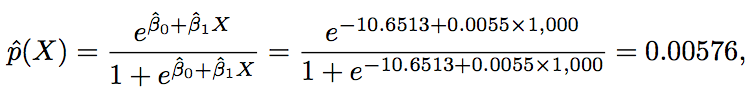

which is below 1%. In contrast, the predicted probability of default for an individual with a balance of \$2,000 is much higher, and equals 0.586 or 58.6%.

One can use qualitative predictors with the logistic regression model using the dummy variable approach from Section 3.3.1. As an example, the Default data set contains the qualitative variable student. To fit the model we simply create a dummy variable that takes on a value of 1 for students and 0 for non-students. The logistic regression model that results from predicting probability of default from student status can be seen in Table 4.2. 

### Table 4.2

In [9]:
X_train = sm.add_constant(df.student2)
y = df.default2

est = smf.Logit(y, X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student2,0.4049,0.115,3.520,0.000,0.179,0.630


The coefficient associated with the dummy variable is positive, and the associated p-value is statistically significant. This indicates that students tend to have higher default probabilities than non-students:

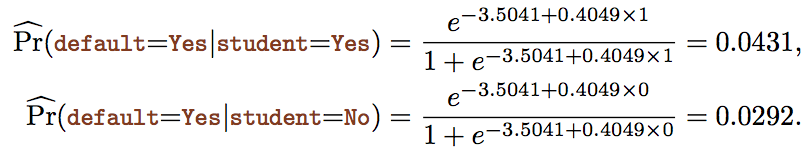

## 4.3.4 Multiple Logistic Regression <a class="anchor" id="multiple-logistic-regression"></a>
Lets now consider the problem of predicting a binary response using multiple predictors. By analogy with the extension from simple to multiple linear regression in Chapter 3, we can generalize

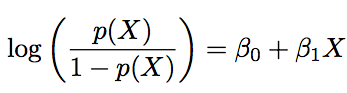

as follows:

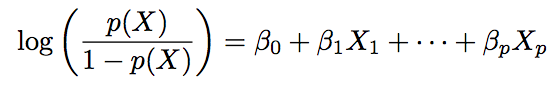

where $X=(X_1,X_2,...,X_p)$ are p predictors. This can then be rewritten as:

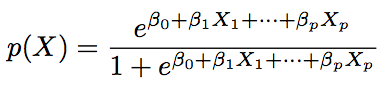

Just as before, we use the maximum likelihood method to estimate β0,β1,...,βp.

### Example of why knowing statistics is so important
Table 4.3 shows the coefficient estimates for a logistic regression model that uses balance, income (in thousands of dollars), and student status to predict probability of default. 

### Table 4.3

In [10]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smf.Logit(y, X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,3.033e-06,8.2e-06,0.370,0.712,-1.3e-05,1.91e-05
student2,-0.6468,0.236,-2.738,0.006,-1.110,-0.184


There is a surprising result here. The p-values associated with balance and the dummy variable for student status are very small, indicating that each of these variables is associated with the probability of default. However, the coefficient for the dummy variable is negative, indicating that students are less likely to default than non- students. In contrast, the coefficient for the dummy variable is positive in Table 4.2. How is it possible for student status to be associated with an increase in probability of default in Table 4.2 and a decrease in probability of default in Table 4.3? The left-hand panel of Figure 4.3 provides a graphical illustration of this apparent paradox. The orange and blue solid lines show the average default rates for students and non-students, respectively,as a function of credit card balance. The negative coefficient for student in the multiple logistic regression indicates that for a fixed value of balance and income, a student is less likely to default than a non-student. Indeed, we observe from the left-hand panel of Figure 4.3 that the student default rate is at or below that of the non-student default rate for every value of balance. But the horizontal broken lines near the base of the plot, which show the default rates for students and non-students averaged over all val- ues of balance and income, suggest the opposite effect: the overall student default rate is higher than the non-student default rate. Consequently, there is a positive coefficient for student in the single variable logistic regression output shown in Table 4.2.

The right-hand panel of Figure 4.3 provides an explanation for this discrepancy. 

### Figure 4.3

In [13]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [15]:
df.groupby(['student','default']).size().unstack('default')

default    No  Yes
student           
No       6850  206
Yes      2817  127

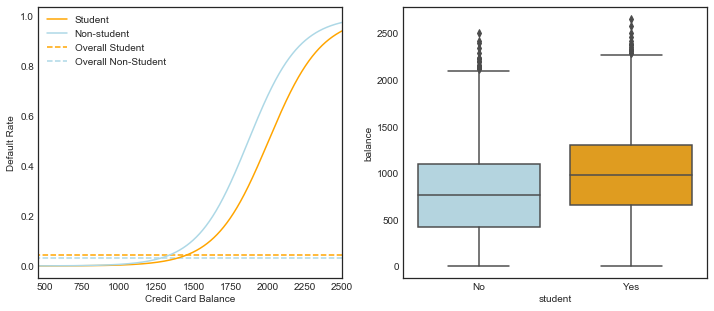

In [16]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);

**The variables student and balance are correlated**. Students tend to hold higher levels of debt, which is in turn associated with higher probability of default. In other words, students are more likely to have large credit card balances, which, as we know from the left-hand panel of Figure 4.3, tend to be associated with high default rates. **Thus, even though an individual student with a given credit card balance will tend to have a lower probability of default than a non-student with the same credit card balance, the fact that students on the whole tend to have higher credit card balances means that overall, students tend to default at a higher rate than non-students.** This is an important distinction for a credit card company that is trying to determine to whom they should offer credit. **A student is riskier than a non-student if no information about the student’s credit card balance is available. However, that student is less risky than a non-student with the same credit card balance!**

This simple example illustrates the dangers and subtleties associated with performing regressions involving only a single predictor when other predictors may also be relevant. As in the linear regression setting, the results obtained using one predictor may be quite different from those obtained using multiple predictors, especially when there is correlation among the predictors. In general, the phenomenon seen in Figure 4.3 is known as **confounding**.


By substituting estimates for the regression coefficients from Table 4.3 into our equation for multiple logistic regression, we can make predictions. For example, a student with a credit card balance of \$1,500 and an income of \$40,000 has an estimated probability of default of:

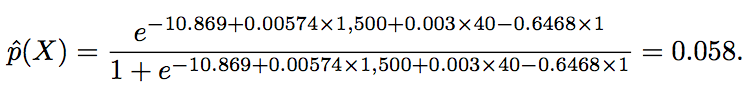

A non-student with the same balance and income has an estimated probability of default of:

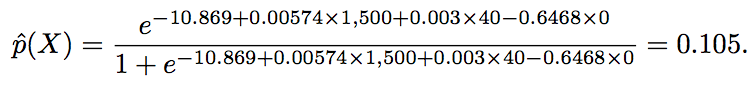

(Note: Here we multiply the income coefficient estimate from Table 4.3 by 40, rather than by 40,000, because in that table the model was fit with income measured in units of \$1,000.)

# 4.4 Linear Discriminant Analysis <a class="anchor" id="linear-discriminant-analysis"></a>
Logistic regression involves directly modeling:
$$Pr(Y=k|X=x)$$ 
using the logistic function, given by: 

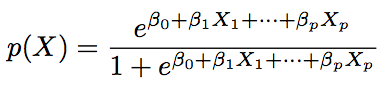

Statistically speaking, we model the conditional response of Y, given the predictors X. We now consider an alternative and less direct approach to estimating these probabilities. In this alternative approach, we model the distribution of the predictors X separately in each of the response classes (i.e. given Y ), and then use Bayes’ theorem to flip these around into estimates for: 
$$Pr(Y=k|X=x)$$ 
When these distributions are assumed to be normal, it turns out that the model is very similar in form to logistic regression.

Why do we need another method, when we have logistic regression? There are several reasons:
* When the classes are well-separated, the parameter estimates for the logistic regression model are surprisingly unstable. Linear discriminant analysis does not suffer from this problem.
* If n is small and the distribution of the predictors X is approximately normal in each of the classes, the linear discriminant model is again more stable than the logistic regression model.
* As mentioned in Section 4.3.5, linear discriminant analysis is popular when we have more than two response classes.

Before conitnuing it is recommended that you watch the following video on LDA: https://www.youtube.com/watch?v=azXCzI57Yfc. 

And read these articles on Bayes Theorem:
* https://betterexplained.com/articles/an-intuitive-and-short-explanation-of-bayes-theorem/
* https://www.analyticsvidhya.com/blog/2016/06/bayesian-statistics-beginners-simple-english/
And watch this video on Bayes:
* https://www.youtube.com/watch?v=5NMxiOGL39M